In [1]:
import os
import sys
import numpy as np
import swyft
import pickle
import matplotlib.pyplot as plt
import torch
import importlib
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
torch.set_float32_matmul_precision('medium')
device_notebook = "cuda" if torch.cuda.is_available() else "cpu"
import wandb
import copy
from torch.multiprocessing import Pool
torch.multiprocessing.set_start_method('spawn',force=True)
torch.set_num_threads(28)
import itertools
import subprocess
from tqdm.auto import tqdm
sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
from explim_functions import generate_expected_limits
import sympy as sy
from scipy.stats import norm, lognorm
from swyft.plot.mass import _get_jefferys_interval as interval
import random

In [2]:
main_dir = "ALPs_with_SWYFT"
thesis_figs = os.getcwd().split(main_dir)[0]+"/"+main_dir+"/thesis_figures/"

In [3]:
names = ['grid_informed_power5',]
gridpoints = [50,55]
colors_priors = ['r','#FFA500','y','g','b', ]

priors = {}
for ip, name in enumerate(names):

    priors[name] = {'name': name}

    priors[name]['results_path'] = '/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/'+name

    priors[name]['store_path'] = priors[name]['results_path']+"/sim_output/store"

    priors[name]['config_vars'] = priors[name]['results_path'] +'/config_variables.pickle'

    priors[name]['config_phys'] = priors[name]['results_path'] +'/physics_variables.pickle'
    
    priors[name]['truncation_record'] = priors[name]['results_path'] +'/truncation_record.pickle'

    removed_ALP_sim=0
    try:
        sys.path.remove('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
        removed_ALP_sim=1
    except ValueError:
        pass
    try:
        del sys.modules['ALP_quick_sim']
    except KeyError:
        pass
    sys.path.append(priors[name]['results_path'])
    import param_function
    import ALP_quick_sim
    with open(priors[name]['config_vars'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['config_phys'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['truncation_record'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    sys.path.remove(priors[name]['results_path'])
    sys.path.append(priors[name]['results_path']+'/train_output/net')
    import network
    sys.path.remove(priors[name]['results_path']+'/train_output/net')
    
    

    priors[name]['net_path'] = {}
    priors[name]['net'] = {}
    for rnd in range(priors[name]['which_truncation']+1):
        round = 'round_'+str(rnd)
        priors[name]['net'][round] = {}
        priors[name]['net_path'][round] = {}
        for gp in gridpoints:
            gridpoint = 'grid_point_' + str(gp)
            priors[name]['net_path'][round][gridpoint] = (priors[name]['results_path'] + '/train_output/net/trained_network_'
                                                             +round+'_gridpoint_'+str(int(gp))+'.pt')

            count = 0
            for combo in itertools.product(*priors[name]['hyperparams'].values()):
                if count == gp:
                    hyperparams_point = {}
                    for i, key in enumerate(priors[name]['hyperparams'].keys()):
                        hyperparams_point[key]=combo[i]
                    break
                count +=1
          
            priors[name]['net'][round][gridpoint] = network.NetworkCorner(
                nbins=priors[name]['A'].nbins,
                marginals=priors[name]['POI_indices'],
                param_names=priors[name]['A'].param_names,
                **hyperparams_point,
            )
            priors[name]['net'][round][gridpoint].load_state_dict(torch.load(priors[name]['net_path'][round][gridpoint]))

    # with open(priors[name]['results_path']+'/explim_predictions.pickle', 'rb') as file:
    #     priors[name]['predictions'] = pickle.load(file)

    if priors[name]['which_truncation'] > 0:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        # store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
    else:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name'])
        # store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim")
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior")
    priors[name]['samples'] = store.get_sample_store()
    # priors[name]['samples_explim'] = store_explim.get_sample_store()
    priors[name]['samples_prior'] = store_prior.get_sample_store()
 
    del sys.modules['param_function']
    del sys.modules['ALP_quick_sim']
    del sys.modules['network']
    if removed_ALP_sim: sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')


/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
trainer = swyft.SwyftTrainer(accelerator = 'cuda', precision = 32,logger=False,)

/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gertwk/.conda/envs/swyft4-dev-notebook/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
sys.path

['/home/gertwk/ALPs_with_SWYFT/notebooks/thesis_results',
 '/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python39.zip',
 '/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9',
 '/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/lib-dynload',
 '',
 '/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages',
 '/tmp/tmplqh3r4do',
 '/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim']

In [6]:
def convert_pair_to_index(pair,n_indices):
    pair = sorted(pair)
    return int((pair[0]+1)*(n_indices-1+n_indices-pair[0]-1)/2 - n_indices + pair[1])

In [7]:
def weight(exp,n_bins):
    x = np.linspace(-1,1,n_bins)
    return 0.5+0.5*np.cos(np.pi*np.sign(x)*np.abs(x)**exp)

In [8]:
stdnorm = norm()

In [9]:
# %%time
# references_2d = [
#                 references2D(priors[name]['samples'][-1000:])[0] for _ in range(1000)
#             ]

In [10]:
len(priors[name]['samples_prior'])

400000

In [11]:
try:
    del sys.modules['DRP_test']
except KeyError:
    pass
try:
    del sys.modules['reference_functions']
except KeyError:
    pass
from DRP_test import get_drp_coverage, get_drp_coverage_torch, draw_DRP_samples_fast
from reference_functions import References
R = References()
references2D = R.references2D

In [12]:
name = names[0]
samples = priors[name]['samples'][-4_000:]
prior_samples = priors[name]['samples_prior'][:400_000]
which_truncation = priors[name]['which_truncation']
which_grid_point = priors[name]['which_grid_point']
POIs = priors[name]['POI_indices']
A = priors[name]['A']
bounds = np.array(priors[name]['bounds_rounds'][which_grid_point][which_truncation])

draws1d = {}
draws2d = {}
weights1d = {}
weights2d = {}
for rnd in range(0,1):
    round = 'round_'+str(rnd)
    draws1d[round],draws2d[round],weights1d[round],weights2d[round] = draw_DRP_samples_fast(
        priors[name]['net'][round]['grid_point_50'],
        trainer,
        samples,
        prior_samples,
        batch_size = 1024*64
    )

Predicting: 0it [00:00, ?it/s]

In [33]:
%%time

def test_DRP_values(tries=3,n_samps=1000, n_prior_samps=1000, n_refs=100, bins=50, gridpoints = gridpoints):
    name = names[0]
    which_truncation = priors[name]['which_truncation']
    which_grid_point = priors[name]['which_grid_point']
    POIs = priors[name]['POI_indices']
    A = priors[name]['A']
    bounds = np.array(priors[name]['bounds_rounds'][which_grid_point][which_truncation])
        
    round = 'round_0'
    validation_sums = {}
    key = list(draws2d[round].keys())[0]
    rows = len(POIs)
    print('Computing references... ', flush=True, end="")
    references_2d = np.array([
        references2D(samples)[0] for _ in range(n_refs)
    ])
    print('done.')
    for gp in gridpoints:
        print()
        gridpoint = "grid_point_"+str(gp)
        print('Gridpoint ' + str(gp))
        validation_sums[gp] = np.zeros(tries)
        
        for trial in range(tries):

            print('Computing trial '+str(trial)+"... ", flush=True, end="\r")
            
            random_indices = random.sample(list(np.arange(len(samples))), n_samps)
            random_prior_indices = random.sample(list(np.arange(len(prior_samples))), n_prior_samps)

            draws = draws2d[round][key][random_prior_indices][:,random_indices,:]
            weights = weights2d[round][key][random_prior_indices][:,random_indices]
            truths = samples['params'][:,[0,1]][random_indices]
            refs = references_2d[:,random_indices]
            
            validation_sum = 0
            for ref_i in range(n_refs): 
                ecp_pp, alpha_pp, _, _, _,_,f_score,_ = get_drp_coverage_torch(
                    draws,
                    truths,
                    weights=weights,
                    theta_names=np.array(A.param_names)[[0,1]],
                    bounds = np.array(bounds)[[0,1]],
                    references = refs[ref_i,:],
                    device='cuda',
                    bins=bins,
                    intermediate_figures=False,
                )
                validation_sum += f_score/n_refs
            
            validation_sums[gp][trial] = validation_sum
            
            # print(validation_sum)
        print('Done.')
        
    return validation_sums
        
        

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.6 µs


In [31]:
def test_theoretical_f_stability(mock_bins=50,mock_n_per_bin=10, mock_n_ref=10_000, mock_tries=1):
    mock_n = mock_bins*mock_n_per_bin 
    mock_alpha = np.linspace(0,1,mock_bins+1)[1:]
    mock_dx = mock_alpha[1]-mock_alpha[0]
    mock_upper = 1+3*mock_n_per_bin**(-0.5)
    mock_lower = 1-3*mock_n_per_bin**(-0.5)
    mock_uncertainty = (mock_upper-mock_lower)/2
    mock_validation_sums = np.zeros((mock_tries,))
    for trial in range(mock_tries):
        # print('Computing trial '+str(trial), flush=True, end='\r')
        mock_validation_sum = 0
        for ref_i in range(mock_n_ref):
            mock_f = np.random.uniform(size=(mock_n,))
            mock_histogram = torch.histogram(torch.tensor(mock_f), density=True, bins=mock_bins ,range=(0,1))
            mock_h = np.array(mock_histogram.hist)
            mock_validation_sum += np.sum(((mock_h-1)/mock_uncertainty)**2)/(mock_n_ref*mock_bins)
        mock_validation_sums[trial] = mock_validation_sum
    # print()
    plt.hist(mock_validation_sums, density=True)

    # print(mock_n)
    # print(mock_alpha)
    # print(mock_n_per_bin)
    # print(mock_uncertainty)

Computing trial 999
Computing trial 999
Computing trial 999
CPU times: user 9h 28min, sys: 27.4 s, total: 9h 28min 27s
Wall time: 20min 25s


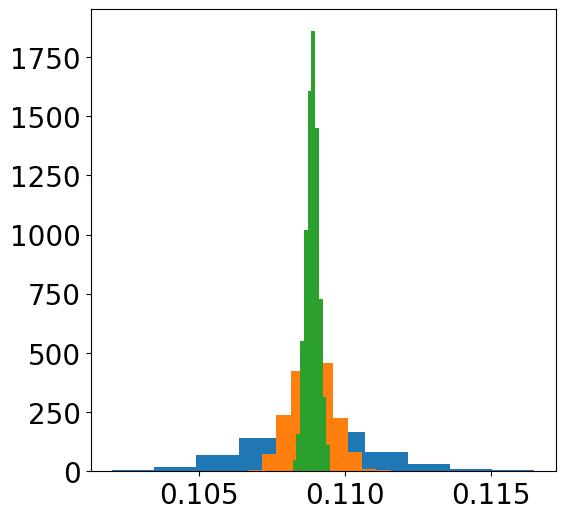

In [15]:
%%time
fig = plt.figure(figsize=(6,6))
fig.add_subplot(1,1,1)
test_theoretical_f_stability(mock_bins=50, mock_n_ref=100, mock_tries=1000, mock_n_per_bin=20)
test_theoretical_f_stability(mock_bins=50, mock_n_ref=1000, mock_tries=1000, mock_n_per_bin=20)
test_theoretical_f_stability(mock_bins=50, mock_n_ref=10_000, mock_tries=1000, mock_n_per_bin=20)

In [56]:
400*15*20

120000

CPU times: user 24min 25s, sys: 997 ms, total: 24min 26s
Wall time: 52.7 s


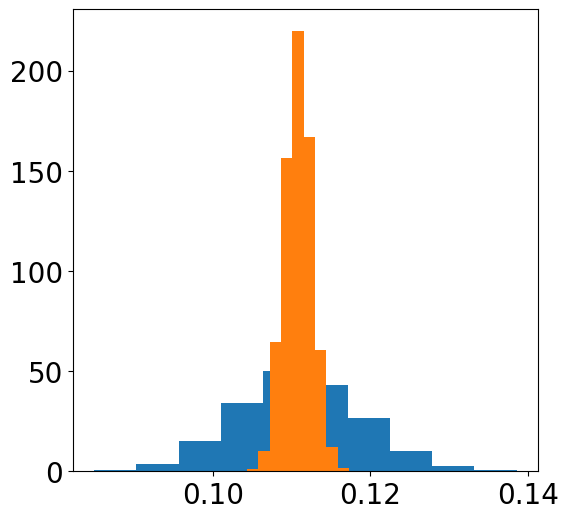

In [59]:
%%time
fig = plt.figure(figsize=(6,6))
fig.add_subplot(1,1,1)
test_theoretical_f_stability(mock_bins=400, mock_n_ref=1, mock_tries=10_000, mock_n_per_bin=15)
test_theoretical_f_stability(mock_bins=400, mock_n_ref=20, mock_tries=10_000, mock_n_per_bin=15)

CPU times: user 24 s, sys: 58.8 ms, total: 24 s
Wall time: 884 ms


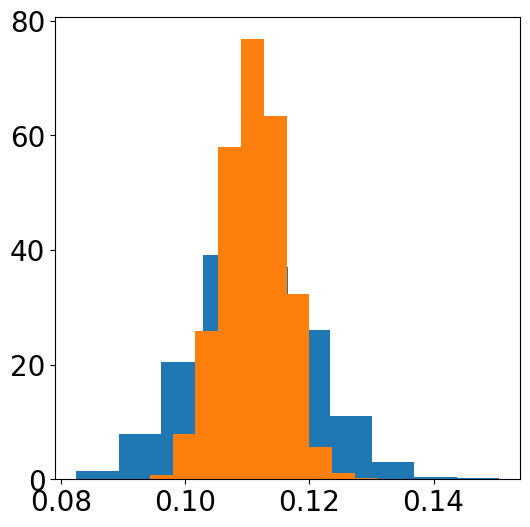

In [42]:
%%time
fig = plt.figure(figsize=(6,6))
fig.add_subplot(1,1,1)
# test_theoretical_f_stability(mock_bins=2, mock_n_ref=1, mock_tries=1000, mock_n_per_bin=15)
# test_theoretical_f_stability(mock_bins=10, mock_n_ref=1, mock_tries=1000, mock_n_per_bin=15)
# test_theoretical_f_stability(mock_bins=50, mock_n_ref=1, mock_tries=1000, mock_n_per_bin=15)
# test_theoretical_f_stability(mock_bins=100, mock_n_ref=1, mock_tries=1000, mock_n_per_bin=15)
test_theoretical_f_stability(mock_bins=265, mock_n_ref=1, mock_tries=1000, mock_n_per_bin=15)
test_theoretical_f_stability(mock_bins=1000, mock_n_ref=1, mock_tries=1000, mock_n_per_bin=15)

In [45]:
sums01

{50: array([0.11968428, 0.11601211, 0.11404133, 0.10026413, 0.11517752])}

In [44]:
sums01 = test_DRP_values(tries = 5, n_samps=4_000, bins=265, n_refs=1, n_prior_samps=80_000, gridpoints=[50])

Computing references... done.

Gridpoint 50
Done.ting trial 4... 


In [40]:
%%time
sums0 = test_DRP_values(tries = 5, n_samps=4_000, bins=265, n_refs=1, n_prior_samps=80_000, gridpoints=[50])

Computing references... done.

Gridpoint 50
Done.ting trial 4... 
CPU times: user 2min 17s, sys: 16.6 s, total: 2min 34s
Wall time: 2min 33s


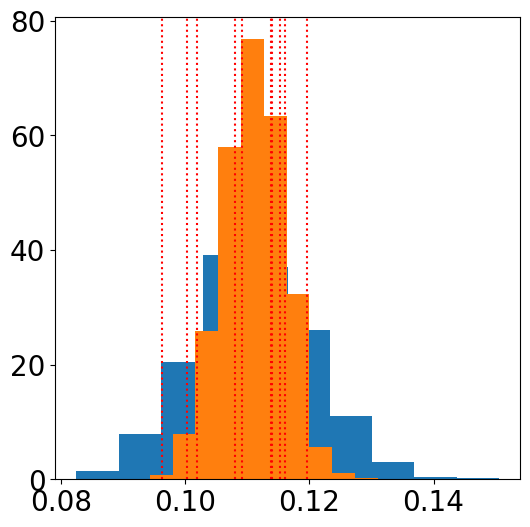

In [46]:
sums = sums0
new_fig = copy.deepcopy(fig)
for gp, gridpoint in enumerate([50]):
    color = ['r','g'][gp]
    for s in sums[gridpoint]:
        new_fig.axes[0].axvline(s, color=color, linestyle=':')
    for s in sums01[gridpoint]:
        new_fig.axes[0].axvline(s, color=color, linestyle=':')
new_fig

In [47]:
sums01 = test_DRP_values(tries = 5, n_samps=4_000, bins=265, n_refs=1, n_prior_samps=10_000, gridpoints=[50])

Computing references... done.

Gridpoint 50
Done.ting trial 4... 


In [48]:
%%time
sums0 = test_DRP_values(tries = 5, n_samps=4_000, bins=265, n_refs=1, n_prior_samps=10_000, gridpoints=[50])

Computing references... done.

Gridpoint 50
Done.ting trial 4... 
CPU times: user 12.4 s, sys: 890 ms, total: 13.3 s
Wall time: 12.6 s


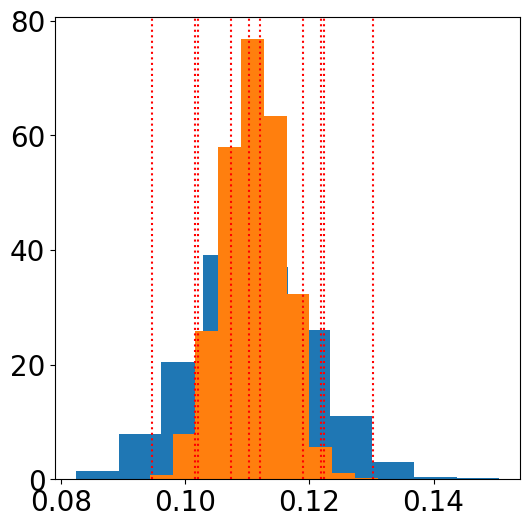

In [49]:
sums = sums0
new_fig = copy.deepcopy(fig)
for gp, gridpoint in enumerate([50]):
    color = ['r','g'][gp]
    for s in sums[gridpoint]:
        new_fig.axes[0].axvline(s, color=color, linestyle=':')
    for s in sums01[gridpoint]:
        new_fig.axes[0].axvline(s, color=color, linestyle=':')
new_fig

In [16]:
%%time
sums1 = test_DRP_values(tries = 5, n_samps=1000, n_refs=100, n_prior_samps=80_000, gridpoints=[50])

Computing references... Fitting samples... done.
done.

Gridpoint 50
Done.ting trial 4... 
CPU times: user 3min 25s, sys: 9.8 s, total: 3min 35s
Wall time: 2min 13s


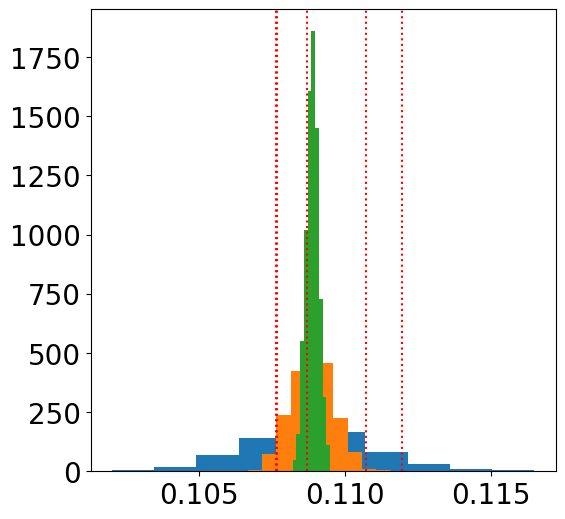

In [17]:
sums = sums1
new_fig = copy.deepcopy(fig)
for gp, gridpoint in enumerate([50]):
    color = ['r','g'][gp]
    for s in sums[gridpoint]:
        new_fig.axes[0].axvline(s, color=color, linestyle=':')
new_fig

In [18]:
%%time
sums2 = test_DRP_values(tries = 5, n_samps=1000, n_refs=1000, n_prior_samps=80_000, gridpoints=[50])

Computing references... done.

Gridpoint 50
Done.ting trial 4... 
CPU times: user 28min 7s, sys: 17.6 s, total: 28min 25s
Wall time: 14min 47s


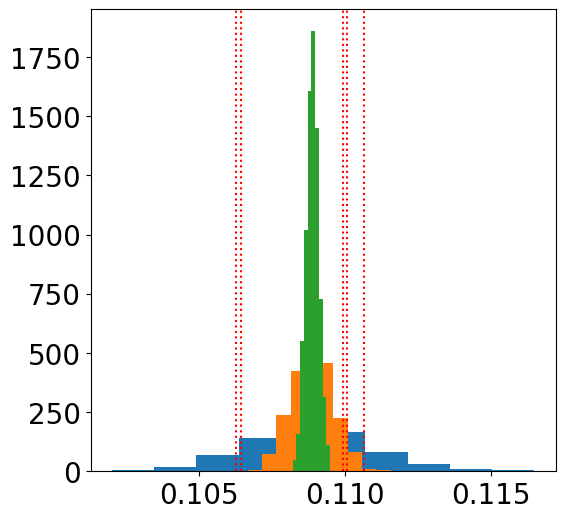

In [19]:
sums = sums2
new_fig = copy.deepcopy(fig)
for gp, gridpoint in enumerate([50]):
    color = ['r','g'][gp]
    for s in sums[gridpoint]:
        new_fig.axes[0].axvline(s, color=color, linestyle=':')
new_fig

In [20]:
%%time
sums3 = test_DRP_values(tries = 5, n_samps=1000, n_refs=10_000, n_prior_samps=80_000, gridpoints=[50])

Computing references... done.

Gridpoint 50
Done.ting trial 4... 
CPU times: user 4h 33min 16s, sys: 1min 43s, total: 4h 34min 59s
Wall time: 2h 18min 49s


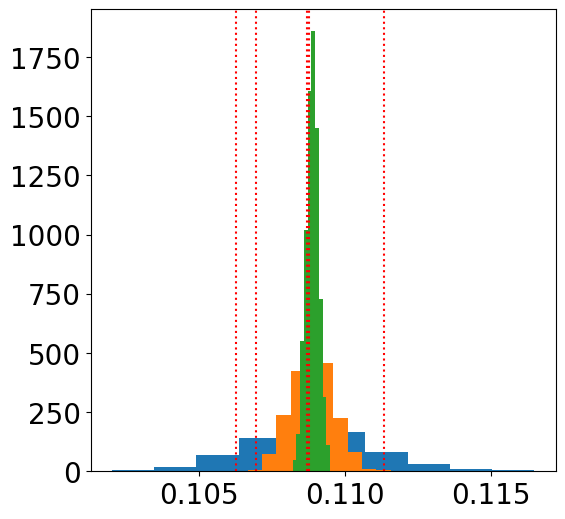

In [21]:
sums = sums3
new_fig = copy.deepcopy(fig)
for gp, gridpoint in enumerate([50]):
    color = ['r','g'][gp]
    for s in sums[gridpoint]:
        new_fig.axes[0].axvline(s, color=color, linestyle=':')
new_fig

In [22]:
%%time
sums4 = test_DRP_values(tries = 5, n_samps=1000, n_refs=100, n_prior_samps=400_00)

Computing references... done.

Gridpoint 50
Done.ting trial 4... 

Gridpoint 55
Done.ting trial 4... 
CPU times: user 4min 34s, sys: 20.7 s, total: 4min 55s
Wall time: 2min 11s


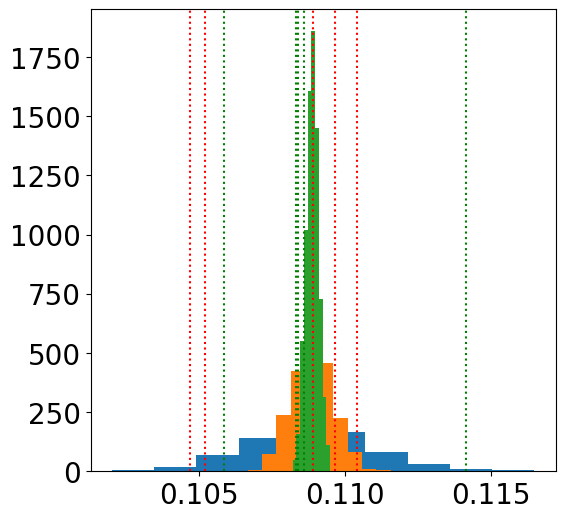

In [23]:
sums = sums4
new_fig = copy.deepcopy(fig)
for gp, gridpoint in enumerate([50]):
    color = ['r','g'][gp]
    for s in sums[gridpoint]:
        new_fig.axes[0].axvline(s, color=color, linestyle=':')
new_fig

In [24]:
%%time
sums5 = test_DRP_values(tries = 5, n_samps=1000, n_refs=1_000, n_prior_samps=400_00)

Computing references... done.

Gridpoint 50
Done.ting trial 4... 

Gridpoint 55
Done.ting trial 4... 
CPU times: user 40min 43s, sys: 19.6 s, total: 41min 2s
Wall time: 13min 45s


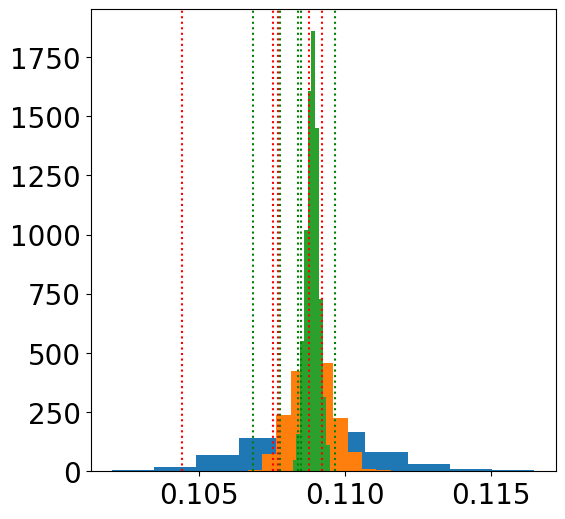

In [25]:
sums = sums5
new_fig = copy.deepcopy(fig)
for gp, gridpoint in enumerate(gridpoints):
    color = ['r','g'][gp]
    for s in sums[gridpoint]:
        new_fig.axes[0].axvline(s, color=color, linestyle=':')
new_fig

In [26]:
%%time
sums6 = test_DRP_values(tries = 5, n_samps=1000, n_refs=10_000, n_prior_samps=400_00)

Computing references... done.

Gridpoint 50
Done.ting trial 4... 

Gridpoint 55
Done.ting trial 4... 
CPU times: user 6h 33min 57s, sys: 1min 17s, total: 6h 35min 15s
Wall time: 2h 2min 14s


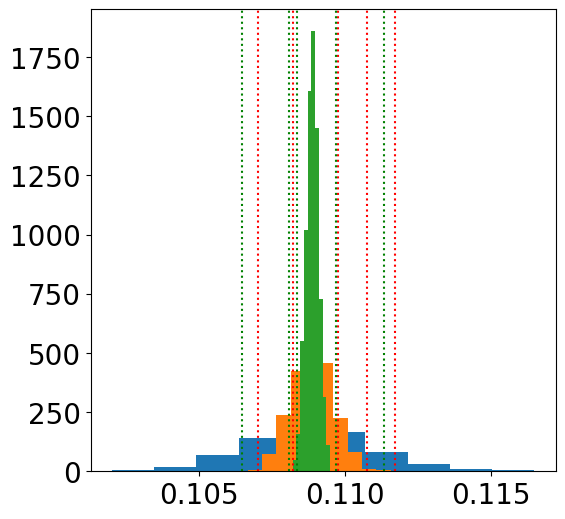

In [27]:
sums = sums6
new_fig = copy.deepcopy(fig)
for gp, gridpoint in enumerate(gridpoints):
    color = ['r','g'][gp]
    for s in sums[gridpoint]:
        new_fig.axes[0].axvline(s, color=color, linestyle=':')
new_fig